Created on Tuesday 12 January 2021

Group 5 - Classification

@authors : F.B

In [1]:
!python3 -m spacy download fr_core_news_md

     |████████████████████████████████| 88.6MB 1.3MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.2.5-cp36-none-any.whl size=90338490 sha256=91d2093b999e846e17a814ad1b00432d89999f7d6f2d444ef4f594e63a730b4d
  Stored in directory: /tmp/pip-ephem-wheel-cache-jaqi51xi/wheels/c6/18/b6/f628642acc7872a53cf81269dd1c394d96da69564ccfac5425
Successfully built fr-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/G5 Inter-Promo 2021/Données/Input")

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from nltk.stem import  WordNetLemmatizer
lemmer=WordNetLemmatizer()
import nltk
nltk.download('wordnet')

from textblob import TextBlob
import spacy

import fr_core_news_md
nlp = fr_core_news_md.load()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
data_feat=pd.read_json('Data_With_Features_Syntax_v1.json')
data_feat.fillna('', inplace=True)
data_feat.head()

,art_id,art_content,art_content_html,art_extract_datetime,art_lang,art_title,art_url,src_name,src_type,src_url,src_img,art_auth,art_tag,Nb_key_words,Nb_key_words_title,Nb_words,Nb_words_title,Nb_sentences,average_word_sentence,ratio_word_title_on_word,exclamation,interrogation,ratio_key_words,ratio_key_sentences,ratio_key_word_title,netloc.com,nb_word_path,content_postive_score,title_postive_score,content_negative_score,title_negative_score,content_polarity_score,title_polarity_score,content_subjectivity_score,title_subjectivity_score,art_content_prepd
0,1,La FNCDG et l’ANDCDG ont publié en septembre l...,"<p style=""text-align: justify;"">La FNCDG et l’...",22 septembre 2020,fr,9ème édition du Panorama de l’emploi territorial,http://fncdg.com/9eme-edition-du-panorama-de-l...,FNCDG,xpath_source,http://fncdg.com/actualites/,http://fncdg.com/wp-content/uploads/2020/09/im...,,,0,0,26,7,3,8.666667,0.175000,0,0,0.000000,0.000000,0.000000,['.com'],7,0.00,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,fncdg andcdg publie septembre eme edition pano...
1,2,Malgré la levée des mesures de confinement le ...,"<p style=""text-align: justify;"">Malgré la levé...",17 mars 2020,fr,ACTUALITÉS FNCDG / COVID19,http://fncdg.com/actualites-covid19/,FNCDG,xpath_source,http://fncdg.com/actualites/,http://fncdg.com/wp-content/uploads/2020/03/co...,,,0,0,85,3,4,21.250000,0.025478,0,0,0.000000,0.000000,0.000000,['.com'],2,0.03,0.0,0.000,0.0,0.400000,0.0,1.000000,0.0,malgre levee mesure confinement mai plupart me...
2,25,Quels étaient les objectifs poursuivis par le ...,"<p style=""text-align: justify;""><strong>Quels ...",24 octobre 2019,fr,"Interview de M. Olivier DUSSOPT, Secretaire d’...",http://fncdg.com/interview-de-m-olivier-dussop...,FNCDG,xpath_source,http://fncdg.com/actualites/,http://fncdg.com/wp-content/uploads/2019/10/in...,,,2,0,740,19,54,13.703704,0.014179,0,4,0.002703,0.037037,0.000000,['.com'],19,0.00,0.0,0.006,0.0,0.026786,0.1,0.261905,0.1,quels etaient objectif poursuivis gouvernement...
3,27,"La journée thématique, qui aura lieu durant le...","<p style=""text-align: justify;""><strong>La jo...",31 mai 2017,fr,Journée Thématique FNCDG « Les services de san...,http://fncdg.com/journee-thematique-fncdg-les-...,FNCDG,xpath_source,http://fncdg.com/actualites/,http://fncdg.com/wp-content/uploads/2017/05/pu...,,,0,1,76,13,3,25.333333,0.104839,0,0,0.000000,0.000000,0.076923,['.com'],11,0.00,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,journee thematique lieu durant salon preventic...
4,28,La 1ère journée thématique en région sur le th...,"<p style=""text-align: justify;"">La 1<sup>ère</...",13 mars 2017,fr,Journée Thématique FNCDG « Vers de nouveaux mo...,http://fncdg.com/journee-thematique-fncdg-vers...,FNCDG,xpath_source,http://fncdg.com/actualites/,http://fncdg.com/wp-content/uploads/2017/03/Sa...,,,0,0,114,12,5,22.800000,0.065934,0,0,0.000000,0.000000,0.000000,['.com'],10,0.00,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,ere journee thematique region theme ver nouvea...


In [7]:
data_feat.shape

(7460, 36)

In [8]:
data = data_feat[['Nb_key_words', 'Nb_key_words_title', 'ratio_key_words', 'ratio_key_sentences', 'ratio_key_word_title']]
data.head()

,Nb_key_words,Nb_key_words_title,ratio_key_words,ratio_key_sentences,ratio_key_word_title
0,0,0,0.000000,0.000000,0.000000
1,0,0,0.000000,0.000000,0.000000
2,2,0,0.002703,0.037037,0.000000
3,0,1,0.000000,0.000000,0.076923
4,0,0,0.000000,0.000000,0.000000


In [9]:
# This function projects the data dataframe onto the keywords, 
# then normalises and calculates the sum of the keywords for each item. 

def sum_keyword(data: pd.DataFrame = data)-> pd.DataFrame:
  """
  Parameters :
    data : default the bow dataframe 
  Output :
    data : dataframe
  
  """
  data_scale = scaler.fit_transform(data)
  data = pd.DataFrame(data_scale, index=data.index, columns=data.columns)
  data['sum_keyword'] = np.sum(data.T).tolist()
  return data

In [10]:
data = sum_keyword()
data.head()

,Nb_key_words,Nb_key_words_title,ratio_key_words,ratio_key_sentences,ratio_key_word_title,sum_keyword
0,-0.549975,-0.278732,-0.555703,-0.407026,-0.227153,-2.018589
1,-0.549975,-0.278732,-0.555703,-0.407026,-0.227153,-2.018589
2,-0.204490,-0.278732,-0.332660,-0.291203,-0.227153,-1.334237
3,-0.549975,3.037600,-0.555703,-0.407026,2.041374,3.566270
4,-0.549975,-0.278732,-0.555703,-0.407026,-0.227153,-2.018589


In [11]:
# Distribution of the sum of keywords
data.sum_keyword.describe()

count    7.460000e+03
mean     3.792439e-15
std      3.421309e+00
min     -2.018589e+00
25%     -2.018589e+00
50%     -1.193777e+00
75%      3.063857e-01
max      3.921822e+01
Name: sum_keyword, dtype: float64

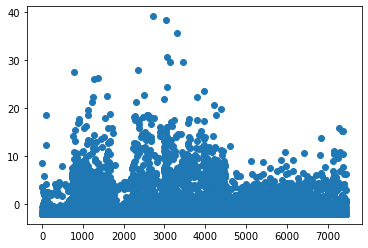

In [12]:
# Visualization
plt.scatter(range(len(data)),data.sum_keyword.values.tolist())

In [13]:
# This function with a threshold separates the dataframe in 2. 
# Its explanatory variables and its variable to be explained

def threshold_breakdown(threshold : int, data : pd.DataFrame) -> tuple :
  """
  Parameter :
    threshold : threshold
    data : dataframe
  Output :
    X, y 
  """
  # Thresholding
  index_no_innovation = data[data['sum_keyword']<=threshold].index.tolist()
  index_innovation = data[data['sum_keyword']>threshold].index.tolist()

  # Labelling
  data.loc[index_no_innovation, 'label_innovation'] = 0
  data.loc[index_innovation, 'label_innovation'] = 1

  # Training
  X = data.drop(['label_innovation','sum_keyword'], axis=1)
  y = data.label_innovation.values
  return X, y

100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


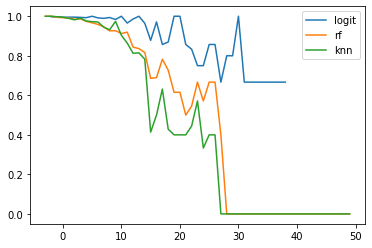

CPU times: user 23.4 s, sys: 2.13 s, total: 25.6 s
Wall time: 23.7 s


In [14]:
# Searching for the optimal threshold to differentiate
#  between innovative and non-innovative products per model. 
%%time
data : pd.DataFrame = sum_keyword()
m :int = int(min(data.sum_keyword.tolist()))-1

scores :list = []
ss :list = []

models = {
    'logit' : LogisticRegression(),
    'rf' : RandomForestClassifier(),
    'knn': KNeighborsClassifier()
}

for j in tqdm(models.keys()):
  score : list = []
  s : list = []
  for i in range(m, 50,1):

    X, y = threshold_breakdown(i,  data)
    X_train, X_val, Y_train, Y_val = train_test_split (X, y, test_size = 0.30, random_state = 40) 
    try :
      model = models[j]
      model.fit(X_train, Y_train)
      y_pred = model.predict(X_val)
      score.append(f1_score(Y_val, y_pred))
      s.append(i)
    except :
      pass
  scores.append(score)
  ss.append(s)
  plt.plot(s, score, label=j)
  plt.legend()
plt.show()

In [25]:
threshold = 0
data = sum_keyword()
X, y = threshold_breakdown(threshold,  data)

In [26]:
# this function allows you to train a model either by cross validation 
# and display its accuracy and f1_score or by simple training 
# and display its accuracy and f1_score and also its confusion matrix if you wish.

def training(model, if_plot : bool = False, if_val_cross : bool = False) :
  """
  Parameters :
    model : model
    if_plot : if you want to display your confusion matrix
    if_val_cross : if you want to train by cross-validation
    Output :
  """
  if if_val_cross :
    print("accuracy ...")
    print(cross_val_score(model, X, y, cv=5))

    print("f1_score ...")
    print(cross_val_score(model, X, y, cv=5, scoring='f1'))

  else :

    X_train, X_val, Y_train, Y_val = train_test_split (X, y, test_size = 0.30, random_state = 40) 
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_val)

    print("accuracy ...")
    print(model.score(X_val, Y_val))
    print("f1_score ...")
    print(f1_score(Y_val, y_pred))

    if if_plot:
      plot_confusion_matrix(model, X_val, Y_val, cmap='Blues', normalize=None,
                      display_labels=['No innovation', 'Innovation']);

accuracy ...
0.9973190348525469
f1_score ...
0.9951140065146581


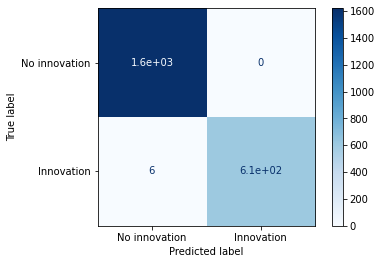

In [27]:
# Logit 

model = LogisticRegression()
training(model, True)

In [28]:
# Logit 

training(model, False, True)

accuracy ...
[0.99664879 0.99865952 0.99932976 0.99664879 0.99396783]
f1_score ...
[0.99411072 0.99764706 0.99882214 0.99408284 0.98929845]


# The most important keywords

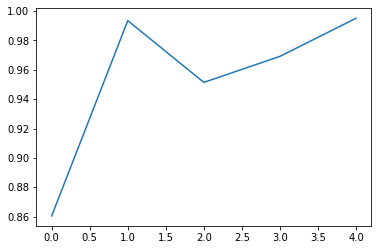

CPU times: user 357 ms, sys: 219 ms, total: 577 ms
Wall time: 339 ms


In [29]:
# Delete a keyword and see its impact on the f1_score
%%time

score : list = []

columns = data.columns.tolist()
columns.remove('label_innovation')
columns.remove('sum_keyword')

for col in columns:

  X = data.drop(['label_innovation','sum_keyword',col], axis=1)
  y = data.label_innovation.values
  X_train, X_val, Y_train, Y_val = train_test_split (X, y, test_size = 0.30, random_state = 40) 
  
  try :
    model = LogisticRegression()
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_val)
    score.append(f1_score(Y_val, y_pred))
  except :
    pass
plt.plot(score)
#plt.legend()
plt.show()

In [31]:
# The most important keywords

ind : list = np.where(np.array(score)<0.99)[0].tolist()
key_importants : list = []
for i in ind:
  col = columns[i]
  print(col)
  key_importants.append(col)

Nb_key_words
ratio_key_words
ratio_key_sentences


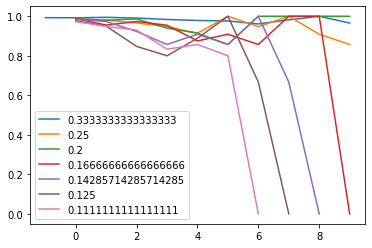

CPU times: user 3.26 s, sys: 2.61 s, total: 5.87 s
Wall time: 3.05 s


In [32]:
# For each weight assigned to the keywords, the least important ones, 
# display the f1_score in relation to the threshold.
%%time

data_copy : pd.DataFrame = data.copy()

weigths = [1/3, 1/4, 1/5, 1/6, 1/7, 1/8, 1/9]
for w in  weigths:
  for col in data.columns:
    if col in key_importants :
      data_copy[col]= data_copy[col]*(1-w)
    else :
      data_copy[col]= data_copy[col]*w

  data_copy.drop(['sum_keyword', 'label_innovation'], axis=1, inplace=True)
  data_copy['sum_keyword'] = np.sum(data_copy.T).tolist()

  m : int = int(min(data_copy.sum_keyword.tolist())) - 1
  score : list = []
  s : list = []
  for i in range(m,10,1):

    X, y = threshold_breakdown(i,  data_copy)
    
    X_train, X_val, Y_train, Y_val = train_test_split (X, y, test_size = 0.30, random_state = 40) 
    try :
      model = LogisticRegression()
      model.fit(X_train, Y_train)
      y_pred = model.predict(X_val)
      score.append(f1_score(Y_val, y_pred))
      s.append(i)
    except :
      pass

  plt.plot(s, score, label=w)
  plt.legend()
plt.show()

In [40]:
threshold : int = 0
data : pd.DataFrame = sum_keyword()
data_copy : pd.DataFrame = data.copy()

w : float = 1/3
for col in data.columns:
  if col in key_importants :
    data_copy[col]= data[col]*(1-w)
  else :
    data_copy[col]= data[col]*w

data_copy.drop(['sum_keyword'], axis=1, inplace=True)
data_copy['sum_keyword'] = np.sum(data_copy.T).tolist()

X, y = threshold_breakdown(threshold,  data_copy)

accuracy ...
0.9950848972296693
f1_score ...
0.9921484653818701


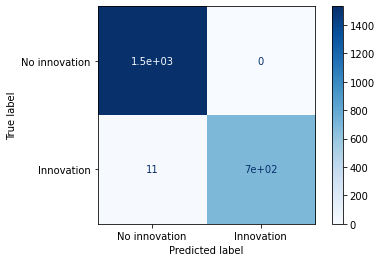

In [42]:
model = LogisticRegression()
training(model, True)

In [43]:
training(model, False, True)

accuracy ...
[0.99463807 0.99530831 0.99865952 0.99597855 0.98994638]
f1_score ...
[0.99154334 0.99263933 0.99789916 0.99367089 0.98402556]


In [39]:
# We notice that the f1_score is approximately equal to 1 and the recall is equal to 1. 
# So the labeling is good.

# Output 

In [45]:
label = pd.DataFrame()
label['art_id'] = data_feat.art_id.tolist()
label['label_innovation'] = data_copy.label_innovation.tolist()
label.head()

,art_id,label_innovation
0,1,0.0
1,2,0.0
2,25,0.0
3,27,1.0
4,28,0.0


In [46]:
label['label_innovation'] = label['label_innovation'].astype(int)
label.head()

,art_id,label_innovation
0,1,0
1,2,0
2,25,0
3,27,1
4,28,0


In [47]:
y=label.label_innovation
print('The number of relevant documents :',len(y[y==1]))

The number of relevant documents : 2385


In [48]:
label.to_csv("../Output/Innovation/label__supervised_data_feat.csv", index=False)